# Chapter 14. 통계 모델링
1) Patsy를 이용한 통계 모델 정의

2) 선형회귀

3) 이산 회귀 분석

4) 시계열

### 모듈 임포트하기

In [1]:
# statsmodel 라이브러리는 통계적 모델을 정의하고, 이를 관측 데이터에 적합화시커기 위한 클래스와 함수는 물론,
# 선형 회귀, 로지스틱 회귀, 시계열 분석 등의 통계 검정이나 모델링과 관련된 기능 제공
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

## patsy를 이용한 통계 모델 정의

In [12]:
np.random.seed(123456789)

In [13]:
y = np.array([1, 2, 3, 4, 5]) # 관측값

In [14]:
x1 = np.array([6, 7, 8, 9, 10]) # 독립변수 1
x2 = np.array([11, 12, 13, 14, 15]) # 독립변수 2

In [15]:
X = np.vstack([np.ones(5), x1, x2, x1*x2]).T # vstack: 우변 항의 설계행렬을 구성하는 함수 (X=[1, x1, x2, x1x2])
X

array([[  1.,   6.,  11.,  66.],
       [  1.,   7.,  12.,  84.],
       [  1.,   8.,  13., 104.],
       [  1.,   9.,  14., 126.],
       [  1.,  10.,  15., 150.]])

In [16]:
beta, res, rank, sval = np.linalg.lstsq(X, y)
beta # 설계행렬 X와 관측벡터 y가 주어지면 최소자승적합화를 사용해 미지 계수 벡터 B를 찾을 수 있음

<ipython-input-16-d7ec1d5971c7>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta, res, rank, sval = np.linalg.lstsq(X, y)


array([-5.55555556e-01,  1.88888889e+00, -8.88888889e-01, -8.88900666e-16])

#### * 위 방법으로는 더 복잡한 모델이나 모델 정의를 쉽게 변경하기 어렵다. 따라서 Patsy가 필요함
#### * Patsy는 모델을 정의하고 관련 설계 행렬을 자동으로 구성하기에 편리한 유형의 언어를 제공

In [17]:
data = {"y": y, "x1": x1, "x2": x2}
y, X = patsy.dmatrices("y ~ 1 + x1 + x2 + x1*x2", data) 
# dmatrices: 첫 번째 인수로 공식의 문자열, 두번째 인수로 반응과 설명 변수의 데이터 배열을 닥셔너리류의 객체를 취한다

In [18]:
y # 설명변수 x1과 x2의 선형 조합

DesignMatrix with shape (5, 1)
  y
  1
  2
  3
  4
  5
  Terms:
    'y' (column 0)

In [19]:
X

DesignMatrix with shape (5, 4)
  Intercept  x1  x2  x1:x2
          1   6  11     66
          1   7  12     84
          1   8  13    104
          1   9  14    126
          1  10  15    150
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'x2' (column 2)
    'x1:x2' (column 3)

In [20]:
type(X) # DesignMatrix 유형으로，Patsy에서 제공되는 표준 Numpy 배열의 하위 클래스이며 추가 메타데이터와 변경된 출력 표현을 가진다.

patsy.design_info.DesignMatrix

In [21]:
np.array(X)

array([[  1.,   6.,  11.,  66.],
       [  1.,   7.,  12.,  84.],
       [  1.,   8.,  13., 104.],
       [  1.,   9.,  14., 126.],
       [  1.,  10.,  15., 150.]])

In [23]:
df_data = pd.DataFrame(data) # dataframe으로 설정하면 Pandas DataFrame 객체 형태로 설계 행렬을 반환
y, X = patsy.dmatrices("y ~ 1 + x1 + x2 + x1:x2", df_data, return_type="dataframe")
X

,Intercept,x1,x2,x1:x2
0,1.0,6.0,11.0,66.0
1,1.0,7.0,12.0,84.0
2,1.0,8.0,13.0,104.0
3,1.0,9.0,14.0,126.0
4,1.0,10.0,15.0,150.0


In [24]:
model = sm.OLS(y, X) # 선형회귀를 수행하기 위해 OLS 클래스 사용
result = model.fit() # 모델을 설계 행렬로 인코딩된 데이터에 실제로 적합화하려면 fit메서드를 실행
result.params

Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -1.110223e-15
dtype: float64

In [25]:
# API(smf로 임포트한 모률)를 이용하면 인스턴스를 생성시 
# 모델에 대한 Patsy 공식을 직접 전달할 수 있으므로 디자인 행렬을 먼저 만들 필요가 없음
model = smf.ols("y ~ 1 + x1 + x2 + x1:x2", df_data)
result = model.fit()
result.params

Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -1.110223e-15
dtype: float64

#### *  모델 공식의 기본 구문은 "LHS ~ RHS" 의 형태로 돼 있다. 
#### * ~ 문자는 모델 방정식의 좌변(LHS)과 우변(RHS)을 분리히는 데 사용

In [26]:
from collections import defaultdict
data = defaultdict(lambda: np.array([1,2,3]))
patsy.dmatrices("y ~ a", data=data)[1].design_info.term_names

['Intercept', 'a']

In [38]:
patsy.dmatrices("y ~ 1 + a + b", data=data)[1].design_info.term_names

['Intercept', 'a', 'b']

In [39]:
patsy.dmatrices("y ~ -1 + a + b", data=data)[1].design_info.term_names

['a', 'b']

In [40]:
patsy.dmatrices("y ~ a * b", data=data)[1].design_info.term_names

['Intercept', 'a', 'b', 'a:b']

In [41]:
patsy.dmatrices("y ~ a * b * c", data=data)[1].design_info.term_names

['Intercept', 'a', 'b', 'a:b', 'c', 'a:c', 'b:c', 'a:b:c']

In [42]:
patsy.dmatrices("y ~ a * b * c - a:b:c", data=data)[1].design_info.term_names

['Intercept', 'a', 'b', 'a:b', 'c', 'a:c', 'b:c']

In [43]:
data = {k: np.array([]) for k in ["y", "a", "b", "c"]}

In [44]:
patsy.dmatrices("y ~ a + b", data=data)[1].design_info.term_names

['Intercept', 'a', 'b']

In [45]:
patsy.dmatrices("y ~ I(a + b)", data=data)[1].design_info.term_names

['Intercept', 'I(a + b)']

In [46]:
patsy.dmatrices("y ~ a*a", data=data)[1].design_info.term_names

['Intercept', 'a']

In [47]:
patsy.dmatrices("y ~ I(a**2)", data=data)[1].design_info.term_names

['Intercept', 'I(a ** 2)']

In [48]:
patsy.dmatrices("y ~ np.log(a) + b", data=data)[1].design_info.term_names

['Intercept', 'np.log(a)', 'b']

In [49]:
z = lambda x1, x2: x1+x2

In [50]:
patsy.dmatrices("y ~ z(a, b)", data=data)[1].design_info.term_names

['Intercept', 'z(a, b)']

### 범주형 변수
수치 데이터 유형(float 또는 int)이 아닌 변수는 모두 범주형 변수로 해석하고 자동으로 인코딩한다.

수치 변수는 C(x) 표기법을 사용하면 변수를 범주형 변수로 취급하도록 명시적으로 지정할 수 있다.

In [28]:
data = {"y": [1, 2, 3], "a": [1, 2, 3]} # 수치인 경우
patsy.dmatrices("y ~ - 1 + a", data=data, return_type="dataframe")[1]

,a
0,1.0
1,2.0
2,3.0


In [32]:
patsy.dmatrices("y ~ - 1 + C(a)", data=data, return_type="dataframe")[1] # 범주형인 경우
# 원래 변수의 개별 값에서 마스크처럼 인코딩한 새로운 이진 열이 설계 행렬에 추가됨.

,C(a)[type A],C(a)[type B],C(a)[type C]
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [33]:
data = {"y": [1, 2, 3], "a": ["type A", "type B", "type C"]} # 비수치값을 갖는 경우
patsy.dmatrices("y ~ - 1 + a", data=data, return_type="dataframe")[1] # 자동으로 범주형으로 해석돼 처리됨.

,a[type A],a[type B],a[type C]
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [34]:
# 직교 다항식으로 인코딩하도록하려면 C(a , Poly) 처럼 지정
patsy.dmatrices("y ~ - 1 + C(a, Poly)", data=data, return_type="dataframe")[1]

,"C(a, Poly).Constant","C(a, Poly).Linear","C(a, Poly).Quadratic"
0,1.0,-7.071068e-01,0.408248
1,1.0,-4.433780e-17,-0.816497
2,1.0,7.071068e-01,0.408248


## 선형회귀
1. model = sm.MODEL(y, X)나 model = smf.model(formula, data)를 사용해 모델 클래스의 인스턴스를 생성
2. 모델 인스턴스를 생성할 때는 어떠한 연산도 수행하지 않는다. 모델을 데이터에 적합화하려면 fit 메서드를 result = model.fit()처럼 호출해야 한다. 적합화를 수행한 후 추가 분석을 위한 메서드와 속성을 가진 결과 객체가 반환된다. 
3. fit 메서드가 반환한 결과 객체의 요약 통계량을 출력한다. summary 메서드는 통계 모델이 데이터를 성공적으로 설명하는지 판단하는 데 유용한 몇 가지 유형의 통계가 포함된 적합화 결과를 기술한 요약문을 출력한다. 
4. 모댈 적합화 결과 후처리 summary 메서드에 더해 결과 객체는 적합화된 매개변수(params), 모델과 데이터의 잔차{resid，적합화(fittedvalues)을 구하고 새로운 독립 변수로 반응 변숫값을 예측하는 메서드(preclict) 등의 여러 메서드와 속성도 갖고있다.
5. Matplotlib나 Seaborn 그래픽 라이브러리를 사용해 적합화 결과를 시각화 해보면 유용하다.

In [87]:
np.random.seed(123456789)
N = 100
x1 = np.random.randn(N)
x2 = np.random.randn(N)
data = pd.DataFrame({"x1": x1, "x2": x2}) #Pandas의 DataFrame 객체에 데이터를 저장

In [88]:
def y_true(x1, x2): # y참값을 DataFrame 객체 data의 y_true 열에 저장
    return 1  + 2 * x1 + 3 * x2 + 4 * x1 * x2
data["y_true"] = y_true(x1, x2)

In [89]:
e = np.random.randn(N)
data["y"] = data["y_true"] + e

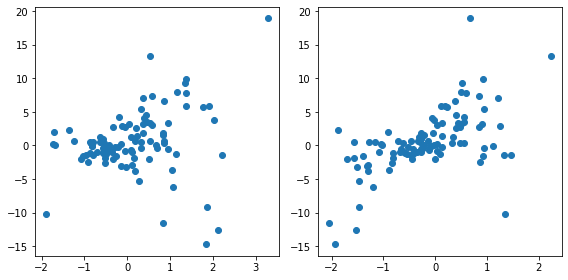

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(data["x1"], data["y"])
axes[1].scatter(data["x2"], data["y"])

fig.tight_layout()

In [91]:
model = smf.ols("y ~ x1 + x2", data)
result = model.fit()

In [92]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     29.76
Date:                Wed, 10 Aug 2022   Prob (F-statistic):           8.36e-11
Time:                        12:13:18   Log-Likelihood:                -271.52
No. Observations:                 100   AIC:                             549.0
Df Residuals:                      97   BIC:                             556.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9868      0.382      2.581      0.0

In [93]:
result.rsquared # rsquared : R-squared 통계량을 명시적으로 알이볼 수 있음

0.3802538325513254

In [94]:
result.resid.head() # resid : 모델의 잔차를 확인

0    -3.370455
1   -11.153477
2   -11.721319
3    -0.948410
4     0.306215
dtype: float64

In [95]:
z, p = stats.normaltest(result.resid.values) # normaltest : 정규성 확인
p # p-value은 실제로 매우 작기 때문에 잔차가 정규분포한다는 귀무 가설을 기각할 수 있다.
# (즉, 잔차의 정규분포 가정이 위반됐다는 결론을 내릴 수 있다) 

4.6524990253009316e-05

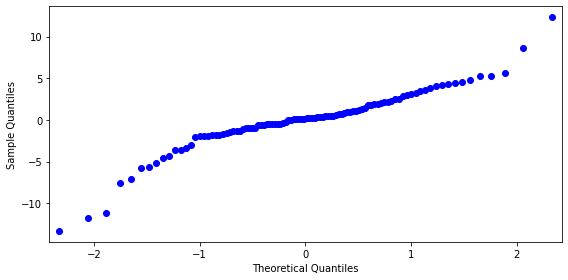

In [96]:
fig, ax = plt.subplots(figsize=(8, 4))
smg.qqplot(result.resid, ax=ax)
# QQ-plot은 선형 관계에서 현저하게 벗어나，관측된 잔차가 정규분포 획률 변수의 표본일 가능성이 낮음을 보여줌
fig.tight_layout()

In [97]:
model = smf.ols("y ~ x1 + x2 + x1*x2", data)
result = model.fit()
print(result.summary()) # R- 제곱이 0.955로 상당히 높으므로 모델과 데이터 사이에 거의 완벽한 일치가 나타남

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     684.5
Date:                Wed, 10 Aug 2022   Prob (F-statistic):           1.21e-64
Time:                        12:13:22   Log-Likelihood:                -140.01
No. Observations:                 100   AIC:                             288.0
Df Residuals:                      96   BIC:                             298.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8706      0.103      8.433      0.0

In [98]:
result.rsquared

0.9553393745884368

In [99]:
z, p = stats.normaltest(result.resid.values)
p

0.22874710482505126

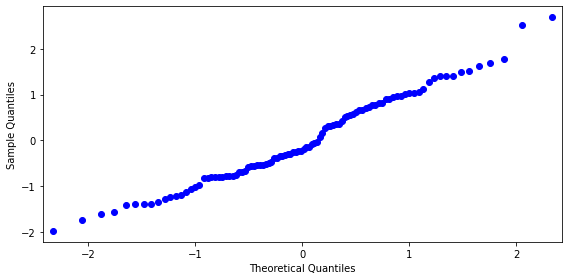

In [101]:
fig, ax = plt.subplots(figsize=(8, 4))
smg.qqplot(result.resid, ax=ax)
fig.tight_layout()

In [112]:
x = np.linspace(-1, 1, 50)
X1, X2 = np.meshgrid(x, x)
new_data = pd.DataFrame({"x1": X1.ravel(), "x2": X2.ravel()})
y_pred = result.predict(new_data) # predict : 예측된 y 값 계산 
y_pred.shape

(2500,)

In [113]:
y_pred = y_pred.values.reshape(50, 50) # y_pred 벡터를 정방 행렬로 조정

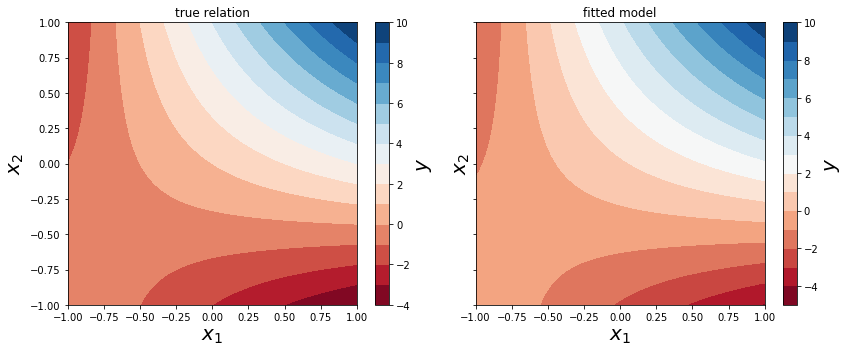

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

def plot_y_contour(ax, Y, title):
    c = ax.contourf(X1, X2, Y, 15, cmap=plt.cm.RdBu)
    ax.set_xlabel(r"$x_1$", fontsize=20)
    ax.set_ylabel(r"$x_2$", fontsize=20)
    ax.set_title(title)
    cb = fig.colorbar(c, ax=ax)
    cb.set_label(r"$y$", fontsize=20)

plot_y_contour(axes[0], y_true(X1, X2), "true relation")
plot_y_contour(axes[1], y_pred, "fitted model")

fig.tight_layout()
fig.savefig("ch14-comparison-model-true.pdf")

### Datasets from R (예제 데이터셋)

In [114]:
dataset = sm.datasets.get_rdataset("Icecream", "Ecdat")

In [115]:
dataset.title

'Ice Cream Consumption'

In [116]:
dataset.data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cons    30 non-null     float64
 1   income  30 non-null     int64  
 2   price   30 non-null     float64
 3   temp    30 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 1.1 KB


In [117]:
model = smf.ols("cons ~ -1 + price + temp", data=dataset.data)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                   cons   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              1001.
Date:                Wed, 10 Aug 2022   Prob (F-statistic):                    9.03e-27
Time:                        12:18:16   Log-Likelihood:                          51.903
No. Observations:                  30   AIC:                                     -99.81
Df Residuals:                      28   BIC:                                     -97.00
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

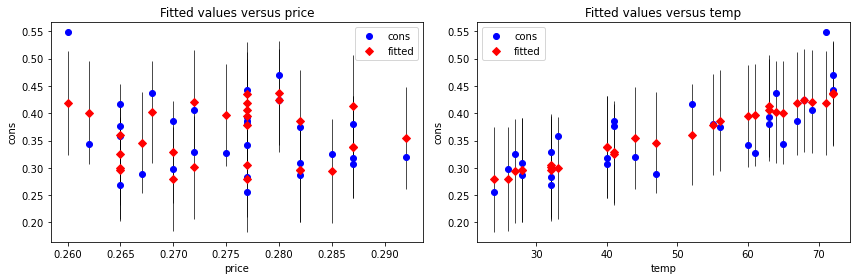

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

smg.plot_fit(result, 0, ax=ax1)
smg.plot_fit(result, 1, ax=ax2)
# Icecream 데이터셋에서 가격과 기온에 대한 소비를 적합화한 회귀 도면
fig.tight_layout()
fig.savefig("ch14-regressionplots.pdf")

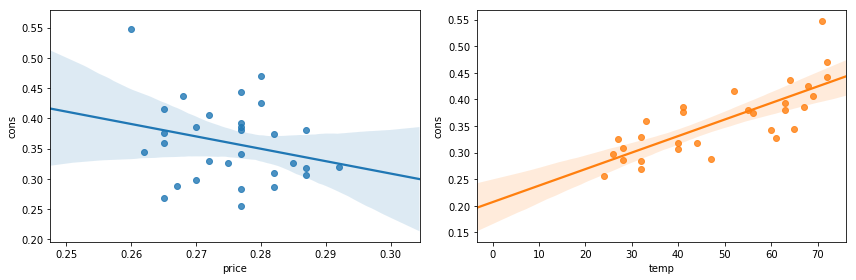

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.regplot("price", "cons", dataset.data, ax=ax1);
sns.regplot("temp", "cons", dataset.data, ax=ax2);

fig.tight_layout()
fig.savefig("ch14-regressionplots-seaborn.pdf")

## 이산 회귀분석
선형회귀와는 다르게 이진 변수나 양의 정숫값을 취하는 변수 등 
가능한 결과값으로 이산값만 갖는 반응 변수에 직접 적용 가능

In [121]:
df = sm.datasets.get_rdataset("iris").data

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [123]:
df.Species.unique() # unique : Species 열에 존재히는 고유한 종의 유형 개수를 출력

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [124]:
df_subset = df[(df.Species == "versicolor") | (df.Species == "virginica" )].copy()
# versicolor와 virginica 두 종의 데이터만 보기위해 새로운 DataFrame 생성

In [125]:
df_subset = df[df.Species.isin(["versicolor", "virginica"])].copy()

In [126]:
df_subset.Species = df_subset.Species.map({"versicolor": 1, "virginica": 0}) # map : 두 종의 이름을 이진값 0과 1로 매핑

In [127]:
df_subset.rename(columns={"Sepal.Length": "Sepal_Length", "Sepal.Width": "Sepal_Width",
                          "Petal.Length": "Petal_Length", "Petal.Width": "Petal_Width"}, inplace=True)

In [128]:
df_subset.head(3)

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1


In [129]:
model = smf.logit("Species ~ Sepal_Length + Sepal_Width + Petal_Length + Petal_Width", data=df_subset)
result = model.fit() # Petal_length와 Petal_Wldth를 독립 변수로 사용

Optimization terminated successfully.
         Current function value: 0.059493
         Iterations 12


In [130]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                Species   No. Observations:                  100
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            4
Date:                Wed, 10 Aug 2022   Pseudo R-squ.:                  0.9142
Time:                        12:25:26   Log-Likelihood:                -5.9493
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 1.947e-26
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       42.6378     25.708      1.659      0.097      -7.748      93.024
Sepal_Length     2.4652      2.394      1.030      0.303      -2.228       7.158
Sepal_Width      6.6809      4.480      1.49

**Note:** Sepal_Length and Sepal_Width do not seem to contribute much to predictiveness of the model. 

In [131]:
model = smf.logit("Species ~ Petal_Length + Petal_Width", data=df_subset)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.102818
         Iterations 10


In [132]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                Species   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Wed, 10 Aug 2022   Pseudo R-squ.:                  0.8517
Time:                        12:26:23   Log-Likelihood:                -10.282
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 2.303e-26
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       45.2723     13.612      3.326      0.001      18.594      71.951
Petal_Length    -5.7545      2.306     -2.496      0.013     -10.274      -1.235
Petal_Width    -10.4467      3.756     -2.78

In [134]:
print(result.get_margeff().summary()) #get_margeff: 모델에서의 각 설명 변수의 한계 영향에 대한 정보를 출력

        Logit Marginal Effects       
Dep. Variable:                Species
Method:                          dydx
At:                           overall
                  dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Petal_Length    -0.1736      0.052     -3.347      0.001      -0.275      -0.072
Petal_Width     -0.3151      0.068     -4.608      0.000      -0.449      -0.181


In [139]:
params = result.params
beta0 = -params['Intercept']/params['Petal_Width']
beta1 = -params['Petal_Length']/params['Petal_Width']

In [140]:
df_new = pd.DataFrame({"Petal_Length": np.random.randn(20)*0.5 + 5,
                       "Petal_Width": np.random.randn(20)*0.5 + 1.7})
df_new["P-Species"] = result.predict(df_new)

In [141]:
df_new["P-Species"].head(3)

0    0.923979
1    0.639992
2    0.999949
Name: P-Species, dtype: float64

In [142]:
df_new["Species"] = (df_new["P-Species"] > 0.5).astype(int)

In [143]:
df_new.head()

,Petal_Length,Petal_Width,P-Species,Species
0,4.563289,1.580889,0.923979,1
1,4.651542,1.716290,0.639992,1
2,5.334275,0.448308,0.999949,1
3,6.372194,1.909420,0.000012,0
4,5.800729,1.632174,0.005715,0


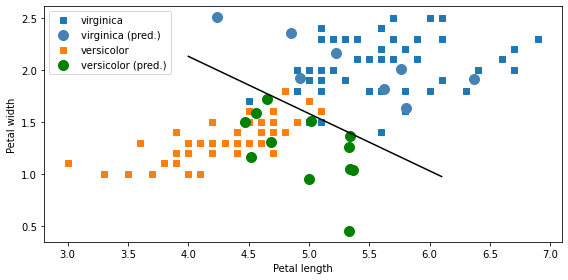

In [144]:
# 꽃잎의 길이와 너비를 독립 변수로 해 아이리스 종을 로직 회귀를 사용해 분류한 결과 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(df_subset[df_subset.Species == 0].Petal_Length.values,
        df_subset[df_subset.Species == 0].Petal_Width.values, 's', label='virginica')
ax.plot(df_new[df_new.Species == 0].Petal_Length.values,
        df_new[df_new.Species == 0].Petal_Width.values,
        'o', markersize=10, color="steelblue", label='virginica (pred.)')

ax.plot(df_subset[df_subset.Species == 1].Petal_Length.values,
        df_subset[df_subset.Species == 1].Petal_Width.values, 's', label='versicolor')
ax.plot(df_new[df_new.Species == 1].Petal_Length.values,
        df_new[df_new.Species == 1].Petal_Width.values,
        'o', markersize=10, color="green", label='versicolor (pred.)')

_x = np.array([4.0, 6.1])
ax.plot(_x, beta0 + beta1 * _x, 'k')

ax.set_xlabel('Petal length')
ax.set_ylabel('Petal width')
ax.legend(loc=2)
fig.tight_layout()
fig.savefig("ch14-logit.pdf")

### 푸아송 모델
낮은 성공 확률을 가진 다수의 시도 중，성공한 횟수를 반응 변수로 가진 모델을 기술하는 프로세스

자 연 로그를 연결 함수로 삼아 일반화 선형 모댈로 처리할 수 있는 모델

In [145]:
dataset = sm.datasets.get_rdataset("discoveries")

In [146]:
df = dataset.data.set_index("time").rename(columns={"value": "discoveries"})

In [147]:
df.head(10).T

time,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869
discoveries,5,3,0,2,0,3,2,3,6,1


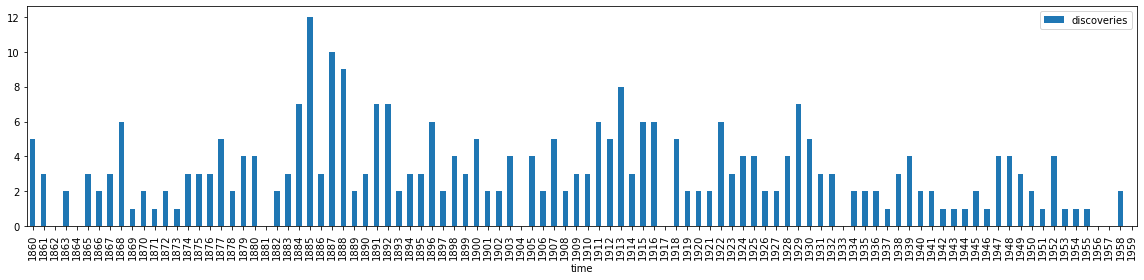

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
df.plot(kind='bar', ax=ax)
fig.tight_layout() # 연간 위대한 발견 개수

In [149]:
model = smf.poisson("discoveries ~ 1", data=df)
result = model.fit()

Optimization terminated successfully.
         Current function value: 2.168457
         Iterations 1


In [150]:
print(result.summary())

                          Poisson Regression Results                          
Dep. Variable:            discoveries   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       99
Method:                           MLE   Df Model:                            0
Date:                Wed, 10 Aug 2022   Pseudo R-squ.:                   0.000
Time:                        12:35:11   Log-Likelihood:                -216.85
converged:                       True   LL-Null:                       -216.85
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1314      0.057     19.920      0.000       1.020       1.243


In [151]:
lmbda = np.exp(result.params) 
X = stats.poisson(lmbda)
result.conf_int() # conf_int : 매개변수의 추정 신뢰 구간을 구함

,0,1
Intercept,1.020084,1.242721


In [152]:
X_ci_l = stats.poisson(np.exp(result.conf_int().values)[0, 0])
X_ci_u = stats.poisson(np.exp(result.conf_int().values)[0, 1])
v, k = np.histogram(df.values, bins=12, range=(0, 12), normed=True)

<ipython-input-152-06fba9c39f00>:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  v, k = np.histogram(df.values, bins=12, range=(0, 12), normed=True)


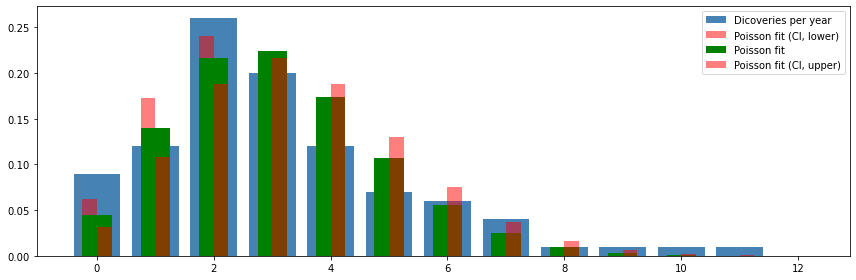

In [153]:
# 연간 위대한 발견 개수의 히스토그램과 적합화된 푸아송 모델의 확률 질량 함수의 비교
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(k[:-1], v, color="steelblue",  align='center', label='Dicoveries per year') 
ax.bar(k-0.125, X_ci_l.pmf(k), color="red", alpha=0.5, align='center', width=0.25, label='Poisson fit (CI, lower)')
ax.bar(k, X.pmf(k), color="green",  align='center', width=0.5, label='Poisson fit')
ax.bar(k+0.125, X_ci_u.pmf(k), color="red",  alpha=0.5, align='center', width=0.25, label='Poisson fit (CI, upper)')

ax.legend()
fig.tight_layout()
fig.savefig("ch14-discoveries-per-year.pdf")
# 푸아송 확률 질량 함수와 관측된 수는 서로 현저하게 벗어나므로 
# 위대한 발견 데이터셋은 푸아송 프로세스로는 잘 설명되지 않는다.

## 시계열
시간의 함수로 관측된 데이터의 미래 값을 분석하고 예측히는 통계 모델링의 중요한 분야다.

관측값의 시계열은 모집단에서 독립적으로 랜덤 추출한 표본의 계열로 간주할 수 없다.

시간적으로 서로 가까운 관측값 사이에는 다소 강한 상관 관계가 있는 경우가 많다.

시계열 모텔에서의 독립 변수는 서로 구분되는 요인의 집합이 아니라 동일한 계열의 과거 관측값이다.

In [154]:
df = pd.read_csv("temperature_outdoor_2014.tsv", header=None, delimiter="\t", names=["time", "temp"])
df.time = pd.to_datetime(df.time, unit="s")
df = df.set_index("time").resample("H").mean()

In [157]:
# 3, 4월의 관측값을 추출해 새로운 DataFrame 객체에 각각 저장
df_march = df[df.index.month == 3]
df_april = df[df.index.month == 4]

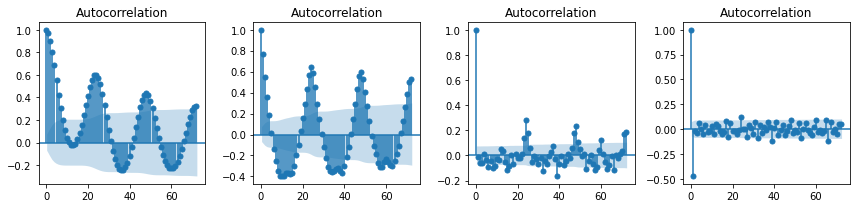

In [159]:
# 좌에서 우로 차분 차수를 증가시켜 가면서 기온 데이터의 자기 상관 함수를 그린 것 
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
smg.tsa.plot_acf(df_march.temp, lags=72, ax=axes[0])
smg.tsa.plot_acf(df_march.temp.diff().dropna(), lags=72, ax=axes[1])
smg.tsa.plot_acf(df_march.temp.diff().diff().dropna(), lags=72, ax=axes[2])
smg.tsa.plot_acf(df_march.temp.diff().diff().diff().dropna(), lags=72, ax=axes[3])
fig.tight_layout()
# 가장 왼쪽 그래프에서 시계열에서 연속된 값 사이의 명확한 상관 관계를 볼 수 있지만
# 차수가 증가되면 시계열 차분은 자기 상관관계를 크게 감소시킴
# 각각의 연속적인 온도 관측은 선행값과 강하게 상관되지만 
# 그러한 상관관계는 연속적인 관측 사이의 고차 변회는 강하지 않다는 것을 시사

In [164]:
model = sm.tsa.AR(df_march.temp)

In [165]:
result = model.fit(72) # 3일간(또는 72 시간)의 기온을 예측하는 것이 목표/ AR 모델의 차수를 72시간으로 맞춤

In [166]:
# 더빈-왓슨 검정은 0에서 4 사이의 값을 반환
# 2에 가까운 값은 시계열에 남은 자기 상관 관계가 없다는 것을 의미
sm.stats.durbin_watson(result.resid)

1.9985623006352897

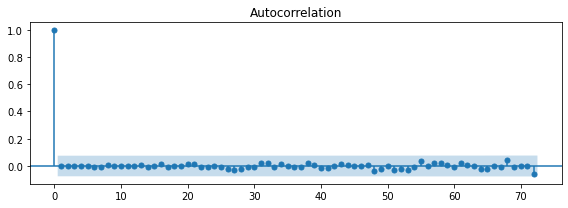

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
smg.tsa.plot_acf(result.resid, lags=72, ax=ax)
fig.tight_layout() #  기온 관측값의 AR(72) 모델의 잔차의 자기 상관 관계 그래프
# plot_acf : 잔차에 대한 자기 상관 함수를 그래프로 표시하고 유의한 자기 상관 관계가 없다는 것을 확인

In [169]:
temp_3d_forecast = result.predict ("2014-04-01", "2014-04-4")

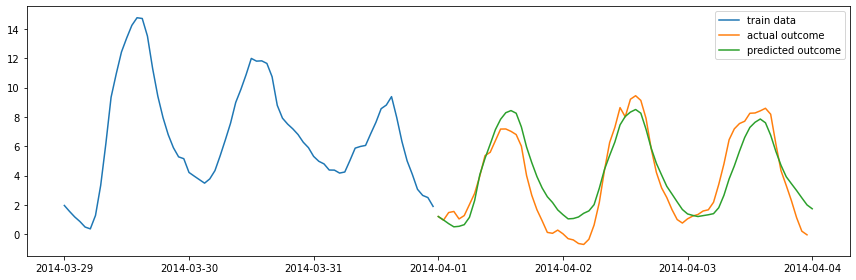

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(df_march.index.values[-72:], df_march.temp.values[-72:], label="train data")
ax.plot(df_april.index.values[:72], df_april.temp.values[:72], label="actual outcome")
ax.plot(pd.date_range("2014-04-01", "2014-04-4", freq="H").values,
        result.predict("2014-04-01", "2014-04-4"), label="predicted outcome")

ax.legend()
fig.tight_layout()
fig.savefig("ch14-timeseries-prediction.pdf")

In [149]:
# Using ARMA model on daily average temperatures

In [150]:
df_march = df_march.resample("D").mean()

In [151]:
df_april = df_april.resample("D").mean()

In [152]:
model = sm.tsa.ARMA(df_march, (4, 1))

In [153]:
result = model.fit()

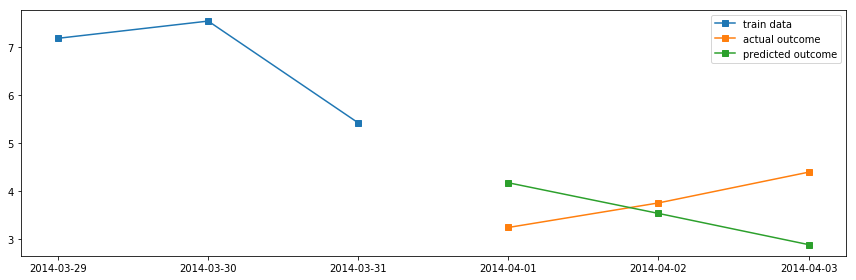

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(df_march.index.values[-3:], df_march.temp.values[-3:], 's-', label="train data")
ax.plot(df_april.index.values[:3], df_april.temp.values[:3], 's-', label="actual outcome")
ax.plot(pd.date_range("2014-04-01", "2014-04-3").values,
        result.predict("2014-04-01", "2014-04-3"), 's-', label="predicted outcome")
ax.legend()
fig.tight_layout()